# SAE-95: Dashboard Analyse Sémantique et Sentiment

**Objectif** : Comprendre le sentiment des utilisateurs et le vocabulaire associé.

**Données** : `data/cleaned/reviews_clean.parquet`

## Plan
1. Chargement des données
2. Analyse 1 : Longueur du message vs Note
3. Analyse 2 : Indice de Satisfaction Global
4. Analyse 3 : Le duel des mots (Word Clouds)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import os

# Config
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
os.makedirs('../outputs/figures', exist_ok=True)

## 1. Chargement des données

In [2]:
data_path = '../data/cleaned/reviews_clean.parquet'

# Chargement d'un échantillon si le fichier est trop gros pour la démo, sinon tout
# Ici on charge tout car on a besoin de stats, mais pour le wordcloud on échantillonnera peut-être
df_reviews = pd.read_parquet(data_path)
print(f"Dimensions: {df_reviews.shape}")
df_reviews.head()

Dimensions: (999985, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53
1,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14
2,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48
3,U9-43s8YUl6GWBFCpxUGEw,PAxc0qpqt5c2kA0rjDFFAg,XwepyB7KjJ-XGJf0vKc6Vg,4,0,0,0,Been here a few times to get some shrimp. They...,2013-04-27 01:55:49
4,8T8EGa_4Cj12M6w8vRgUsQ,BqPR1Dp5Rb_QYs9_fz9RiA,prm5wvpp0OHJBlrvTj9uOg,5,0,0,0,This is one fantastic place to eat whether you...,2019-05-15 18:29:25


## 2. Analyse 1 : Longueur vs Note
Hypothèse : Les avis extrêmes (1 et 5) sont plus longs.

C:\Users\melou\AppData\Local\Temp\ipykernel_24928\3935950419.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length, x='stars', y='char_count', palette='viridis')


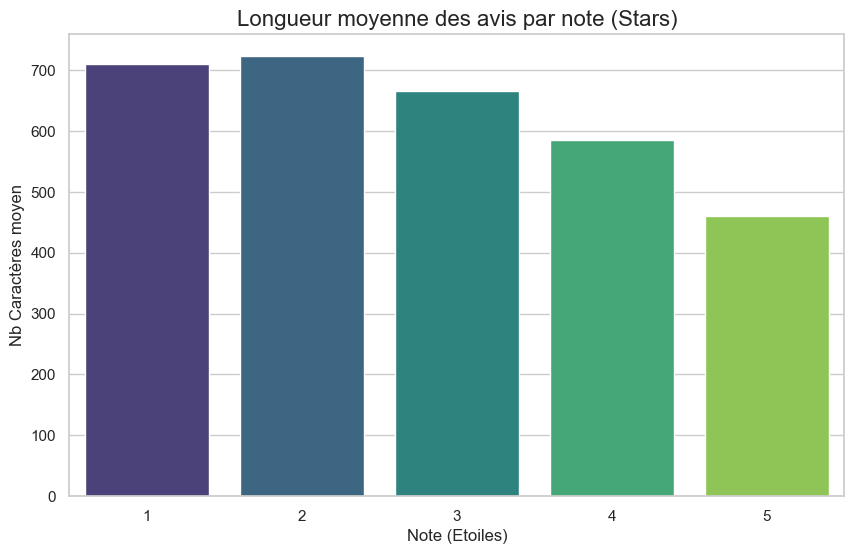

In [3]:
df_reviews['char_count'] = df_reviews['text'].astype(str).apply(len)

avg_length = df_reviews.groupby('stars')['char_count'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_length, x='stars', y='char_count', palette='viridis')
plt.title('Longueur moyenne des avis par note (Stars)', fontsize=16)
plt.xlabel('Note (Etoiles)')
plt.ylabel('Nb Caractères moyen')
plt.savefig('../outputs/figures/sae95_length_vs_stars.png')
plt.show()

## 3. Analyse 2 : Indice de Satisfaction

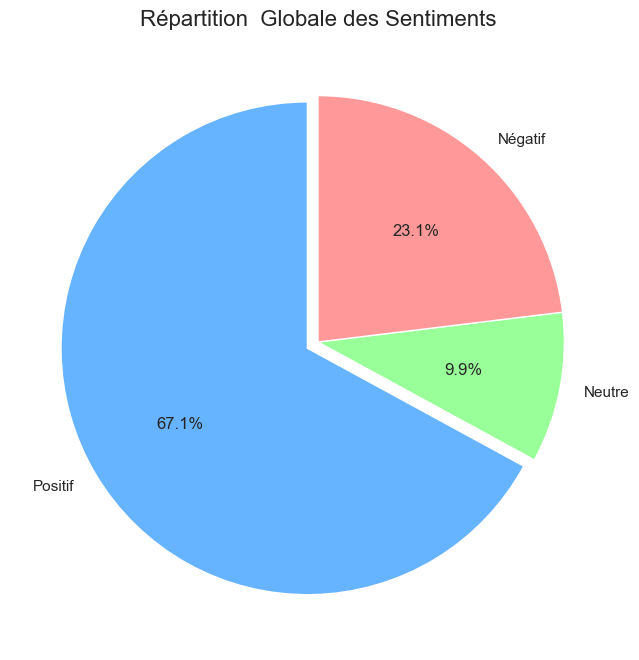

In [4]:
def classify_sentiment(star):
    if star >= 4: return 'Positif'
    elif star <= 2: return 'Négatif'
    else: return 'Neutre'

df_reviews['sentiment'] = df_reviews['stars'].apply(classify_sentiment)
sentiment_counts = df_reviews['sentiment'].value_counts()

# Ordre logique
order = ['Positif', 'Neutre', 'Négatif']
sentiment_counts = sentiment_counts.reindex(order, fill_value=0)

plt.figure(figsize=(8, 8))
colors = ['#66b3ff', '#99ff99', '#ff9999'] # Bleu, Vert, Rouge (adapté)
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0, 0))
plt.title('Répartition  Globale des Sentiments', fontsize=16)
plt.savefig('../outputs/figures/sae95_satisfaction_pie.png')
plt.show()

## 4. Analyse 3 : Le Duel des Mots (WordClouds)
Top mots pour les avis Positifs vs Négatifs.

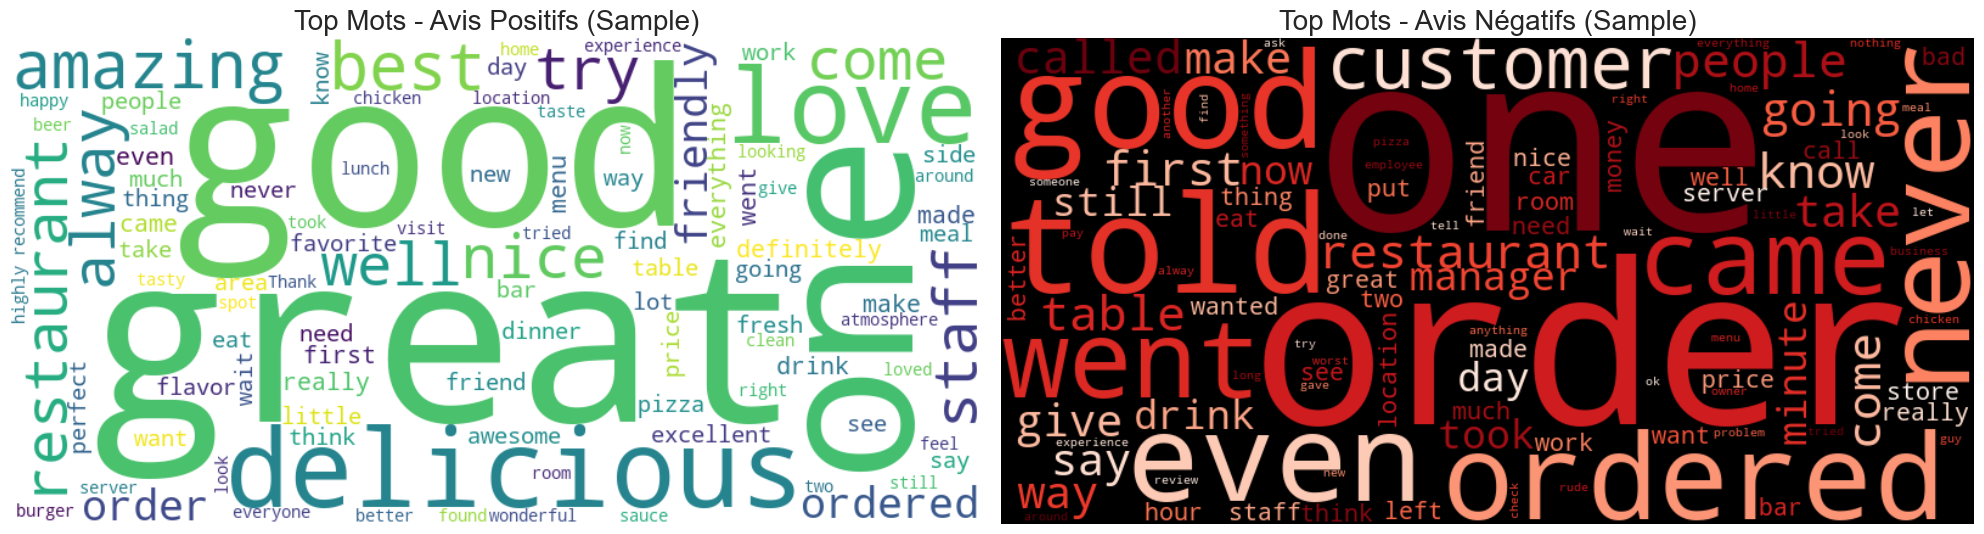

In [5]:
# Sampling pour éviter crash mémoire sur WordCloud si dataset > 1GB
sample_size = 50000
if len(df_reviews) > sample_size:
    df_sample = df_reviews.sample(sample_size, random_state=42)
else:
    df_sample = df_reviews

pos_text = ' '.join(df_sample[df_sample['sentiment'] == 'Positif']['text'].astype(str))
neg_text = ' '.join(df_sample[df_sample['sentiment'] == 'Négatif']['text'].astype(str))

stopwords = set(STOPWORDS)
stopwords.update(['place', 'food', 'service', 'time', 'go', 'back', 'us', 'got', 'said', 'asked', 'will'])

wc_pos = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, max_words=100).generate(pos_text)
wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds', stopwords=stopwords, max_words=100).generate(neg_text)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(wc_pos, interpolation='bilinear')
ax1.set_title('Top Mots - Avis Positifs (Sample)', fontsize=20)
ax1.axis('off')

ax2.imshow(wc_neg, interpolation='bilinear')
ax2.set_title('Top Mots - Avis Négatifs (Sample)', fontsize=20)
ax2.axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/sae95_wordcloud_comparison.png')
plt.show()